In [114]:
import pandas as pd
from os import path

import numpy
from tensorflow.contrib.timeseries.examples import lstm
from tensorflow.contrib.timeseries.python.timeseries.estimators import _TimeSeriesRegressor
from tensorflow.contrib.timeseries.examples.lstm import _LSTMModel
from tensorflow.python.platform import test
from tensorflow.contrib.timeseries.python.timeseries import estimators as ts_estimators
from tensorflow.contrib.timeseries.python.timeseries import model as ts_model
import tensorflow as tf
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt

/home/smrutiranjans/miniconda3/envs/ai/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [116]:
df = pd.read_csv('train_aWnotuB.csv')
df_test = pd.read_csv('test_BdBKkAj.csv')

In [103]:
df.head()

#df.describe()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [117]:
#df['DateTime'] = pd.to_datetime(df['DateTime'])
#df.DateTime = df.DateTime.apply(lambda x: time.mktime(pd.Timestamp(x).to_datetime().timetuple()))
#df['ID'] = df.index
for i in range(1,5):
    df[df['Junction']==i][['ID', 'Vehicles']].to_csv('train%d.csv'%i, index=False)

In [76]:
# class _LSTMModel(ts_model.SequentialTimeSeriesModel):
#   """A time series model-building example using an RNNCell."""

#   def __init__(self, num_units, num_features, dtype=tf.float32):
#     """Initialize/configure the model object.
#     Note that we do not start graph building here. Rather, this object is a
#     configurable factory for TensorFlow graphs which are run by an Estimator.
#     Args:
#       num_units: The number of units in the model's LSTMCell.
#       num_features: The dimensionality of the time series (features per
#         timestep).
#       dtype: The floating point data type to use.
#     """
#     super(_LSTMModel, self).__init__(
#         # Pre-register the metrics we'll be outputting (just a mean here).
#         train_output_names=["mean"],
#         predict_output_names=["mean"],
#         num_features=num_features,
#         dtype=dtype)
#     self._num_units = num_units
#     # Filled in by initialize_graph()
#     self._lstm_cell = None
#     self._lstm_cell_run = None
#     self._predict_from_lstm_output = None

#   def initialize_graph(self, input_statistics):
#     """Save templates for components, which can then be used repeatedly.
#     This method is called every time a new graph is created. It's safe to start
#     adding ops to the current default graph here, but the graph should be
#     constructed from scratch.
#     Args:
#       input_statistics: A math_utils.InputStatistics object.
#     """
#     super(_LSTMModel, self).initialize_graph(input_statistics=input_statistics)
#     self._lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=self._num_units)
#     # Create templates so we don't have to worry about variable reuse.
#     self._lstm_cell_run = tf.make_template(
#         name_="lstm_cell",
#         func_=self._lstm_cell,
#         create_scope_now_=True)
#     # Transforms LSTM output into mean predictions.
#     self._predict_from_lstm_output = tf.make_template(
#         name_="predict_from_lstm_output",
#         func_=lambda inputs: tf.layers.dense(inputs=inputs, units=self.num_features),
#         create_scope_now_=True)

#   def get_start_state(self):
#     """Return initial state for the time series model."""
#     return (
#         # Keeps track of the time associated with this state for error checking.
#         tf.zeros([], dtype=tf.int64),
#         # The previous observation or prediction.
#         tf.zeros([self.num_features], dtype=self.dtype),
#         # The state of the RNNCell (batch dimension removed since this parent
#         # class will broadcast).
#         [tf.squeeze(state_element, axis=0)
#          for state_element
#          in self._lstm_cell.zero_state(batch_size=1, dtype=self.dtype)])

#   def _transform(self, data):
#     """Normalize data based on input statistics to encourage stable training."""
#     mean, variance = self._input_statistics.overall_feature_moments
#     return (data - mean) / variance

#   def _de_transform(self, data):
#     """Transform data back to the input scale."""
#     mean, variance = self._input_statistics.overall_feature_moments
#     return data * variance + mean

#   def _filtering_step(self, current_times, current_values, state, predictions):
#     """Update model state based on observations.
#     Note that we don't do much here aside from computing a loss. In this case
#     it's easier to update the RNN state in _prediction_step, since that covers
#     running the RNN both on observations (from this method) and our own
#     predictions. This distinction can be important for probabilistic models,
#     where repeatedly predicting without filtering should lead to low-confidence
#     predictions.
#     Args:
#       current_times: A [batch size] integer Tensor.
#       current_values: A [batch size, self.num_features] floating point Tensor
#         with new observations.
#       state: The model's state tuple.
#       predictions: The output of the previous `_prediction_step`.
#     Returns:
#       A tuple of new state and a predictions dictionary updated to include a
#       loss (note that we could also return other measures of goodness of fit,
#       although only "loss" will be optimized).
#     """
#     state_from_time, prediction, lstm_state = state
#     with tf.control_dependencies(
#             [tf.assert_equal(current_times, state_from_time)]):
#       transformed_values = self._transform(current_values)
#       # Use mean squared error across features for the loss.
#       predictions["loss"] = tf.reduce_mean(
#           (prediction - transformed_values) ** 2, axis=-1)
#       # Keep track of the new observation in model state. It won't be run
#       # through the LSTM until the next _imputation_step.
#       new_state_tuple = (current_times, transformed_values, lstm_state)
#     return (new_state_tuple, predictions)

#   def _prediction_step(self, current_times, state):
#     """Advance the RNN state using a previous observation or prediction."""
#     _, previous_observation_or_prediction, lstm_state = state
#     lstm_output, new_lstm_state = self._lstm_cell_run(
#         inputs=previous_observation_or_prediction, state=lstm_state)
#     next_prediction = self._predict_from_lstm_output(lstm_output)
#     new_state_tuple = (current_times, next_prediction, new_lstm_state)
#     return new_state_tuple, {"mean": self._de_transform(next_prediction)}

#   def _imputation_step(self, current_times, state):
#     """Advance model state across a gap."""
#     # Does not do anything special if we're jumping across a gap. More advanced
#     # models, especially probabilistic ones, would want a special case that
#     # depends on the gap size.
#     return state

#   def _exogenous_input_step(
#           self, current_times, current_exogenous_regressors, state):
#     """Update model state based on exogenous regressors."""
#     raise NotImplementedError(
#         "Exogenous inputs are not implemented for this example.")

In [111]:
# def train_and_predict(csv_file_name, training_steps=200):
#     """Train and predict using a custom time series model."""
#     # Construct an Estimator from our LSTM model.
#     estimator = _TimeSeriesRegressor(
#         model=_LSTMModel(num_features=1, num_units=128),
#         optimizer=tf.train.AdamOptimizer(0.001))
    
#     reader = tf.contrib.timeseries.CSVReader(
#         csv_file_name,
#         column_names=((tf.contrib.timeseries.TrainEvalFeatures.TIMES,)
#                       + (tf.contrib.timeseries.TrainEvalFeatures.VALUES,)))
    
#     train_input_fn = tf.contrib.timeseries.RandomWindowInputFn(
#         reader, batch_size=4, window_size=32)
    
#     estimator.train(input_fn=train_input_fn, steps=training_steps)
#     evaluation_input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
#     evaluation = estimator.evaluate(input_fn=evaluation_input_fn, steps=1)
#     # Predict starting after the evaluation
#     (predictions,) = tuple(estimator.predict(
#         input_fn=tf.contrib.timeseries.predict_continuation_input_fn(
#             evaluation, steps=100)))
#     times = evaluation["times"][0]
#     observed = evaluation["observed"][0, :, :]
#     predicted_mean = numpy.squeeze(numpy.concatenate(
#         [evaluation["mean"][0], predictions["mean"]], axis=0))
#     all_times = numpy.concatenate([times, predictions["times"]], axis=0)
#     return times, observed, all_times, predicted_mean

In [115]:
lstm.train_and_predict('train1.csv')
#from tensorflow.contrib.timeseries.python.timeseries import TimeS

AttributeError: module 'tensorflow.contrib.timeseries.python.timeseries.estimators' has no attribute 'TimeSeriesRegressor'

In [31]:
def add_date_features(df):
    df['date'] = pd.to_datetime(df['DateTime'])
    dti = pd.DatetimeIndex(df['date'])
    holidays = calendar().holidays(start=dti.min(), end=dti.max())

    df['year'] = dti.year
    df['quarter'] = dti.quarter
    df['month'] = dti.month
    df['week'] = dti.week
    df['weekofyear'] = dti.weekofyear
    df['day'] = dti.day
    df['dayofweek'] = dti.dayofweek
    df['dayofyear'] = dti.dayofyear
    df['hour'] = dti.hour
    df['minofday'] = dti.hour*60+dti.minute
    df['bhour'] = df['hour']
    df['bhour'] = df['bhour'].replace(range(1,8), 0).replace(range(8,19), 1).replace(range(19,24), 0)
    df['holiday'] = dti.isin(holidays)
    df['holiday'] = df['holiday'].map({False:0, True:1})
    
add_date_features(df)
add_date_features(df_test)

# df['year'], df['month'], df['week'], df['day'], df['dayofweek'], df['hour'], df['minofday'] = \
# df['date'].dt.year, df['date'].dt.month, df['date'].dt.week, df['date'].dt.day, df['date'].dt.dayofweek, df['date'].dt.hour, df['date'].dt.hour*60+df['date'].dt.minute

In [32]:
#df.date = df.DateTime.apply(lambda x: time.mktime(pd.Timestamp(x).to_datetime().timetuple()))

In [33]:
# from tsfresh import extract_relevant_features
# extracted_features = extract_relevant_features(df, df.Vehicles, column_sort="DateTime", column_id="Junction", column_value="Vehicles", n_jobs=4)

In [34]:
#vehicles

In [35]:
# #temps = DataFrame(df.Vehicles)
# # dataframe = concat([temps.shift(1), temps], axis=1)
# # dataframe.columns = ['t-1', 't+1']
# def lag(df):
#     vehicles = df.Vehicles
#     dataframe = pd.concat([vehicles.shift(3), vehicles.shift(2), vehicles.shift(1), vehicles], axis=1)
#     dataframe.columns = ['t-3', 't-2', 't-1', 't+1']
#     print(dataframe.head(5))
# vehicles = df.groupby('Junction').apply(lag)

In [36]:
def window_features(df):
    width = 3
    v = df.Vehicles
    shifted = v.shift(width - 1)
    window = shifted.rolling(window=width)
    exp = v.expanding()
    dataframe = pd.concat([window.min(), window.mean(), window.max(), exp.min(), exp.mean(), exp.max(), v], axis=1)
    dataframe.columns = ['s_min', 's_mean', 's_max', 'e_min', 'e_mean', 'e_max', 's_t+1']
    #print(dataframe.head(5))
    return dataframe
#window(df)

def merge_features(df, vehicles):
    df['s_min'] = vehicles['s_min']
    df['s_mean'] = vehicles['s_mean']
    df['s_max'] = vehicles['s_max']
    df['e_min'] = vehicles['e_min']
    df['e_mean'] = vehicles['e_mean']
    df['e_max'] = vehicles['e_max']

#merge_features(df, df.groupby('Junction').apply(window_features))
#merge_features(df_test, df_test.groupby('Junction').apply(window_features))

#vehicles.head()

In [37]:
df['Junction'].unique()

array([1, 2, 3, 4])

In [38]:
# import math

# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back-1):
#         a = dataset[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back, 0])
#     return numpy.array(dataX), numpy.array(dataY)

# numpy.random.seed(7)
# dataframe = df
# dataset = dataframe.values
# dataset = dataset.astype('float32')

# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)
# # split into train and test sets
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# # reshape into X=t and Y=t+1
# look_back = 3
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)
# # reshape input to be [samples, time steps, features]
# trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# # create and fit the LSTM network
# batch_size = 1
# model = Sequential()
# model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
# model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# for i in range(100):
# 	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
# 	model.reset_states()
# # make predictions
# trainPredict = model.predict(trainX, batch_size=batch_size)
# model.reset_states()
# testPredict = model.predict(testX, batch_size=batch_size)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

In [16]:
#df.head()

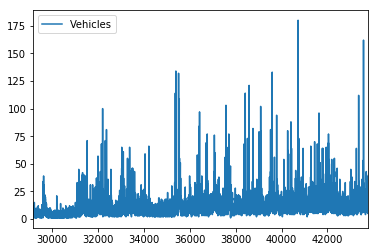

In [39]:
df[df['Junction']==3][['date', 'Vehicles']].plot()

(array([  1.13190000e+04,   2.87900000e+03,   2.79000000e+02,
          6.30000000e+01,   2.60000000e+01,   1.10000000e+01,
          9.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   18.9,   36.8,   54.7,   72.6,   90.5,  108.4,  126.3,
         144.2,  162.1,  180. ]),
 <a list of 10 Patch objects>)

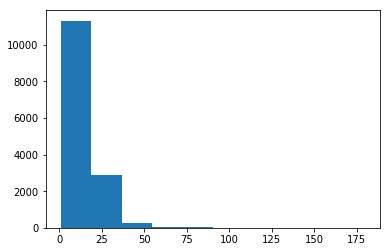

In [40]:
plt.hist(df[df['Junction']==3]['Vehicles'])

In [41]:
# corrmat = df.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);

In [42]:

# sns.set()
# sns.pairplot(df)
# plt.show();

In [43]:
X_test_Id = df_test[['ID']]
df.drop(['ID', 'DateTime', 'date'], inplace=True, axis=1)
df_test.drop(['ID', 'DateTime', 'date'], inplace=True, axis=1)
train, val = np.split(df.sample(frac=1), [int(.99*len(df))])
X_train = train.drop('Vehicles', axis=1)
y_train = train.Vehicles.values
X_val = val.drop('Vehicles', axis=1)
y_val = val.Vehicles.values
X_test = df_test
num_cols = list(X_train.columns.get_values())
num_cols.remove('Junction')
cat_cols = ['Junction']

### Check missing values

In [44]:
pd.isnull(train).sum()

Junction      0
Vehicles      0
year          0
quarter       0
month         0
week          0
weekofyear    0
day           0
dayofweek     0
dayofyear     0
hour          0
minofday      0
bhour         0
holiday       0
dtype: int64

In [45]:
from collections import defaultdict
d = defaultdict(list)
X_train[cat_cols].apply(lambda x: d[x.name].append(x.value_counts().idxmax())) 
ohe = OneHotEncoder().fit(X_train[cat_cols])
#cols = [cat_cols[i] + '=' + str(d[cat_cols[i]].classes_[j]) for i in range(0,len(cat_cols)) for j in range(0,ohe.n_values_[i])]
cols = [cat_cols[i] + '=' + str(j) for i in range(0,len(cat_cols)) for j in range(1,ohe.n_values_[i])]

X_train_cat = pd.DataFrame(ohe.transform(X_train[cat_cols]).toarray(), columns=cols)
X_val_cat = pd.DataFrame(ohe.transform(X_val[cat_cols]).toarray(), columns=cols)
X_test_cat = pd.DataFrame(ohe.transform(X_test[cat_cols]).toarray(), columns=cols)

# from sklearn.feature_extraction import DictVectorizer
# vec = DictVectorizer().fit(X_train[cat_cols].to_dict('records'))
# X_train_cat = pd.DataFrame(vec.transform(X_train[cat_cols].to_dict('records')).toarray(), columns=vec.get_feature_names())
# X_val_cat = pd.DataFrame(vec.transform(X_val[cat_cols].to_dict('records')).toarray(), columns=vec.get_feature_names())
# X_test_cat = pd.DataFrame(vec.transform(X_test[cat_cols].to_dict('records')).toarray(), columns=vec.get_feature_names())

In [46]:
imp_num = Imputer(missing_values='NaN', strategy='mean', axis=0).fit(X_train[num_cols])
X_train[num_cols] = imp_num.transform(X_train[num_cols])
X_val[num_cols] = imp_num.transform(X_val[num_cols])
X_test[num_cols] = imp_num.transform(X_test[num_cols])

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train[num_cols])
X_train_num = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols)
X_val_num = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols)
X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

In [48]:
X_train = X_train_num.join(X_train_cat)
X_val = X_val_num.join(X_val_cat)
X_test = X_test_num.join(X_test_cat)

In [49]:
# model = LinearRegression().fit(X_train, y_train)
# model = XGBRegressor().fit(X_train, y_train)

In [ ]:
# lr = LinearRegression()
# svr_lin = SVR(kernel='linear')
# ridge = Ridge(random_state=1)
# svr_rbf = SVR(kernel='rbf')

# from mlxtend.regressor import StackingRegressor
# model = StackingRegressor(regressors=[svr_lin, lr, ridge], 
#                            meta_regressor=svr_rbf)
# model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_val)
metrics.mean_squared_error(y_val, y_pred)

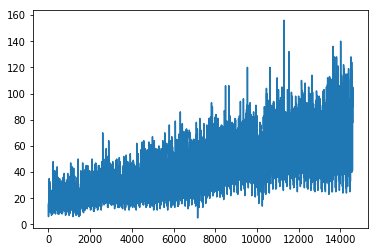

train_dataset: 10214, test_dataset: 5107


fitting model	:   0%|          | 0/100 [00:00<?, ?it/s]/home/smrutiranjans/miniconda3/envs/ai/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


KeyboardInterrupt: 

In [119]:
import numpy
import pandas
import matplotlib.pyplot as plt

from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

from tqdm import trange


# fix random seed for reproducibility
numpy.random.seed(7)


def create_dataset(dataset: numpy.ndarray, look_back: int=1) -> (numpy.ndarray, numpy.ndarray):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        data_x.append(a)
        data_y.append(dataset[i + look_back, 0])
    return numpy.array(data_x), numpy.array(data_y)


def split_dataset(dataset: numpy.ndarray, train_size, look_back) -> (numpy.ndarray, numpy.ndarray):
    """
    Splits dataset into training and test datasets. The last `look_back` rows in train dataset
    will be used as `look_back` for the test dataset.
    :param dataset: source dataset
    :param train_size: specifies the train data size
    :param look_back: number of previous time steps as int
    :return: tuple of training data and test dataset
    """
    if not train_size > look_back:
        raise ValueError('train_size must be lager than look_back')
    train, test = dataset[0:train_size, :], dataset[train_size - look_back:len(dataset), :]
    print('train_dataset: {}, test_dataset: {}'.format(len(train), len(test)))
    return train, test


def build_model(look_back: int, batch_size: int=1) -> Sequential:
    """
    The function builds a keras Sequential model
    :param look_back: number of previous time steps as int
    :param batch_size: batch_size as int, defaults to 1
    :return: keras Sequential model
    """
    model = Sequential()
    model.add(LSTM(64,
                   activation='relu',
                   batch_input_shape=(batch_size, look_back, 1),
                   stateful=True,
                   return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def plot_data(dataset: numpy.ndarray,
              look_back: int,
              train_predict: numpy.ndarray,
              test_predict: numpy.ndarray,
              forecast_predict: numpy.ndarray):
    """
    Plots baseline and predictions.

    blue: baseline
    green: prediction with training data
    red: prediction with test data
    cyan: prediction based on predictions

    :param dataset: dataset used for predictions
    :param look_back: number of previous time steps as int
    :param train_predict: predicted values based on training data
    :param test_predict: predicted values based on test data
    :param forecast_predict: predicted values based on previous predictions
    :return: None
    """
    plt.plot(dataset)
    plt.plot([None for _ in range(look_back)] +
             [x for x in train_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [x for x in test_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [None for _ in test_predict] +
             [x for x in forecast_predict])
    plt.show()


def make_forecast(model: Sequential, look_back_buffer: numpy.ndarray, timesteps: int=1, batch_size: int=1):
    forecast_predict = numpy.empty((0, 1), dtype=numpy.float32)
    for _ in trange(timesteps, desc='predicting data\t', mininterval=1.0):
        # make prediction with current lookback buffer
        cur_predict = model.predict(look_back_buffer, batch_size)
        # add prediction to result
        forecast_predict = numpy.concatenate([forecast_predict, cur_predict], axis=0)
        # add new axis to prediction to make it suitable as input
        cur_predict = numpy.reshape(cur_predict, (cur_predict.shape[1], cur_predict.shape[0], 1))
        # remove oldest prediction from buffer
        look_back_buffer = numpy.delete(look_back_buffer, 0, axis=1)
        # concat buffer with newest prediction
        look_back_buffer = numpy.concatenate([look_back_buffer, cur_predict], axis=1)
    return forecast_predict

# def train(batch_size = 1):
#     models = []
#     for i in range(1,5): 
df = pd.read_csv('train1.csv')
dataset = df[['Vehicles']].values
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
look_back = int(len(dataset) * 0.05)
train_size = int(len(dataset) * 0.70)
train, test = split_dataset(dataset, train_size, look_back)

# reshape into X=t and Y=t+1
train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
train_x = numpy.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = numpy.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))


model = build_model(look_back, batch_size=batch_size)
for _ in trange(100, desc='fitting model\t', mininterval=1.0):
    model.fit(train_x, train_y, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
#     models.append(model)
# return models, train_x, train_y

# generate predictions for training
train_predict = model.predict(train_x, batch_size)
test_predict = model.predict(test_x, batch_size)

# generate forecast predictions
forecast_predict = make_forecast(model, test_x[-1::], timesteps=2952, batch_size=batch_size)

# invert dataset and predictions
dataset = scaler.inverse_transform(dataset)
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])
forecast_predict = scaler.inverse_transform(forecast_predict)

# calculate root mean squared error
train_score = numpy.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
print('Train Score: %.2f RMSE' % train_score)
test_score = numpy.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

plot_data(dataset, look_back, train_predict, test_predict, forecast_predict)

In [25]:
create_dataset(test, look_back)[0][0].shape

(9624,)

In [ ]:
X_test_Id.to_csv('stack_result.csv', index=False)

In [121]:
lst = []
lst.append(1)
lst

[1]